In [1]:
!pip install wordcloud-fa
!pip install gensim

     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 368kB 15.7MB/s 
     |████████████████████████████████| 317kB 18.5MB/s 
     |████████████████████████████████| 1.4MB 19.3MB/s 
     |████████████████████████████████| 235kB 50.0MB/s 
  Created wheel for wordcloud-fa: filename=wordcloud_fa-0.1.8-cp37-none-any.whl size=71015 sha256=aaffec1d66dae4ed0bd4e2c73d528be7d96e5454d9b5afea14bb77e159bc8c06
  Stored in directory: /root/.cache/pip/wheels/37/dd/e9/d6d14e3faa089ffa1bc80ae6f713ca91d2ffd0bb786edcdef5
  Created wheel for nltk: filename=nltk-3.3-cp37-none-any.whl size=1394487 sha256=ae8f19c48a9730da663b0e892ea0483d97b90cb97cef5d66a9e4f43563a33399
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154698 sha256=6b4730cf2607ec16cca27b4e59c5fdd9d764316d2c83f6d7be897cd74589d564
  Stored in directory: /root/.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten

import re
print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.5.0


In [3]:
# df = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/7-offDSA2020-dev-train-8000.xlsx')
df = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/7-offDSA2020-dev-train-8000-MixWithNuhaDS1.xlsx')
df.head()

,tweets,off,hs,new-label
0,فى حاجات مينفعش نلفت نظركوا ليها زى الاصول كده...,NOT_OFF,NOT_HS,not-hate
1,RT @USER: وعيون تنادينا تحايل فينا و نقول يا ع...,NOT_OFF,NOT_HS,not-hate
2,يا بلادي يا أم البلاد يا بلادي بحبك يا مصر بحب...,NOT_OFF,NOT_HS,not-hate
3,RT @USER: يا رب يا قوي يا معين مدّني بالقوة و ...,NOT_OFF,NOT_HS,not-hate
4,RT @USER: رحمك الله يا صدام يا بطل ومقدام. URL,NOT_OFF,NOT_HS,not-hate


In [4]:
#Test data
test = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/test.xlsx')
test.head()

,tweets
0,@USER اما انت تقعد طول عمرك لا مبدا ولا راي ث...
1,@USER @USER بتخاف نسوانك يزعلوا ولا ايه 😂 اه ...
2,RT @USER: يا عـسانـى نـبـقى يا عـمري حـبايـب ...
3,RT @USER: باقي البيان وينو ما شفنه يا برهان <...
4,@USER @USER اللهم انت الشافي المعافي اشفيه وج...


In [5]:
#Actual result data
actual = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/actual.xlsx')
actual.head()


,off
0,OFF
1,OFF
2,NOT_OFF
3,OFF
4,NOT_OFF


In [6]:
df.columns = ['tweets', 'off','hs','new_label']
test.columns = ['tweets']
actual.columns=['off']
df.head()
actual.head()

,off
0,OFF
1,OFF
2,NOT_OFF
3,OFF
4,NOT_OFF


In [7]:
df = df.drop(['hs','new_label'], axis=1)
# test = test.drop(['off'], axis=1)

Text(0.5, 1.0, 'Hate speech Data Distribution')

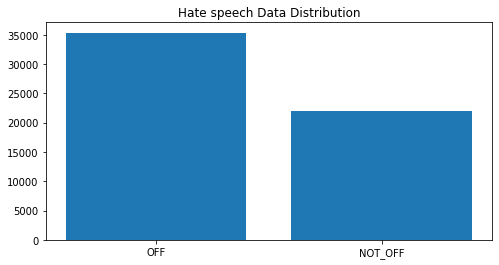

In [8]:
val_count = df.off.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Hate speech Data Distribution")

In [9]:
import random
random_idx_list = [random.randint(1,len(df.tweets)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,tweets,off
1642,@USER <LF>والله مافي حدا بجيب لكم حق بالسمر <L...,NOT_OFF
38207,بل قليها يا جزيرة وعمرها به ا فمك للعملاء الصه...,OFF
46023,الدكتور محمد جواد ظريف دبلوماسي محنك و ليس مرا...,NOT_OFF
57230,@USER @USER @USER تعجبيني يا مرام يا حكيمه 👍 ...,NOT_OFF
41622,إرحل.,NOT_OFF
28825,فتشوا عن يد وزاره الداخليه . لاتستغرب تكون وزا...,OFF
47210,کفی کذب,OFF
42344,الشيطان الاصغر (ايران) قدم قتلى دفاعا عن حكومة...,OFF
49289,ما فعل بسورية والسوريين الا صهيونى نصبه الصهاي...,OFF
39704,هذه الميليشيات الطائفية المجرمة آخرها تقول لبي...,OFF


#Text Preprocessing¶


In [10]:
import gensim

In [11]:
# load the model
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/WE/Twt-CBOW/Twt-CBOW')

In [12]:
text_cleaning_re = "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]|[.#،<>/@,\\-_”“٪ًَ]"
# stop_words = stopwords.words('arabic')
stop_words=[
          'من','في'
]
def preprocess(text):
  # search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!','#']
  # replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ',' ']
  #remove tashkeel
  p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(p_tashkeel,"", str(text))
  # text = text.replace('وو', 'و')
  # text = text.replace('يي', 'ي')
  # text = text.replace('اا', 'ا')
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  #remove longation
  text = re.sub(r'(.)\1+', r'\1\1', str(text)) 
  text = re.sub("[إأآا]", "ا", str(text))
  text = re.sub("ى", "ي", str(text))
  text = re.sub(r'\\', '', str(text))
  # text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", str(text))
  # for i in range(0, len(search)):
  #       text = text.replace(search[i], replace[i])
  
   #trim    
  # text = text.strip()

  tokens = []
  for token in text.split():
    if token not in stop_words:
      tokens.append(token)
  return " ".join(tokens)

In [13]:
stop_words

['من', 'في']

In [14]:
preprocess('هههًه في من على ههه\/ 156562سٌلمُ@#')

'هه علي هه سلم'

In [15]:
word = preprocess(u'حقير')

# find and print the most similar terms to a word
most_similar = model.wv.most_similar( word )
for term, score in most_similar:
	print(term, score)

سافل 0.6879982352256775
خسيس 0.6644033193588257
قذر 0.6214959621429443
منحط 0.6129060983657837
وقح 0.6018147468566895
غبي 0.5982157588005066
وحقير 0.5942843556404114
وسافل 0.5851724743843079
ومنحط 0.5787683725357056
جبان 0.5700664520263672


In [16]:
word_vector = model.wv[ word ]
# word_vector

In [17]:
df.tweets = df.tweets.apply(lambda x: preprocess(x))
df.tweets[:10]
# df.head(10)

0    حاجات مينفعش نلفت نظركوا ليها زي الاصول كده يا...
1    : وعيون تنادينا تحايل فينا و نقول يا عيونه يا ...
2    يا بلادي يا ام البلاد يا بلادي بحبك يا مصر بحب...
3    : يا رب يا قوي يا معين مدني بالقوه و العون و ا...
4                    : رحمك الله يا صدام يا بطل ومقدام
5    يا جابر يا بنجرجي يا مرتزق يا حثاله الحمدين يا...
6    : يا انـت يا بعضــي وكلــي وذاتــي يا لـون الف...
7                    كحل عينك يا منحط يا وضيع يا متخلف
8    لعنه الله عليك يا النذل يا الواطي ولعنه الله ع...
9    يا قلب يا احد الاصغرين كيف اتسعت لهذا الوجود ؟...
Name: tweets, dtype: object

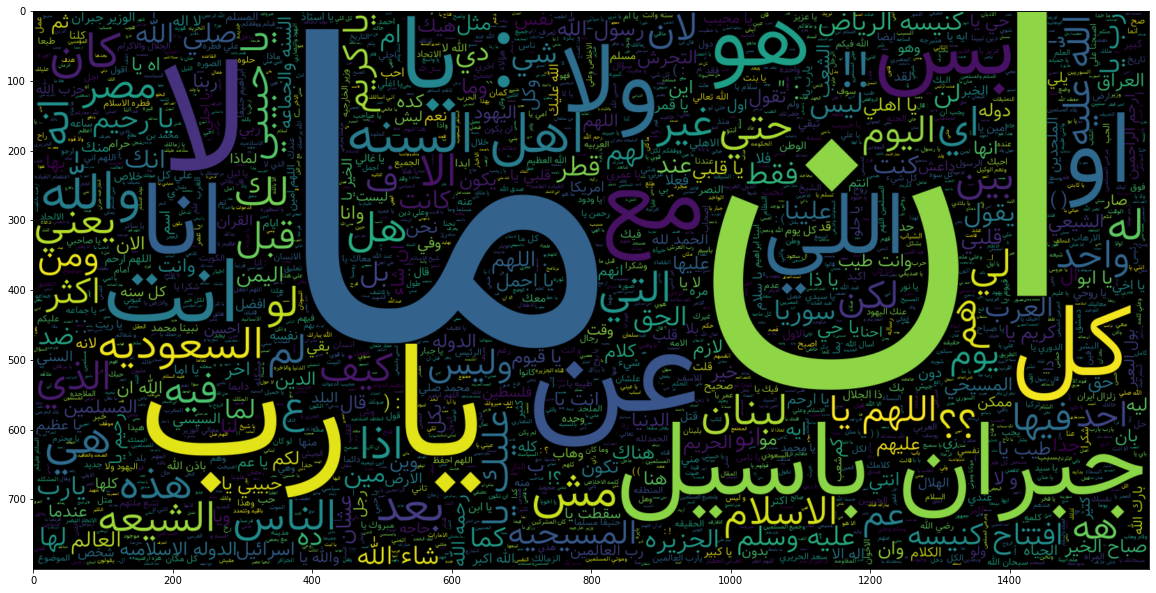

In [18]:
#Not Offensive Words
from wordcloud_fa import WordCloudFa


plt.figure(figsize = (20,20)) 
wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.off == 'NOT_OFF'].tweets))

image = wc.to_image()
image.save('wordcloud.png')
plt.imshow(wc , interpolation = 'bilinear')

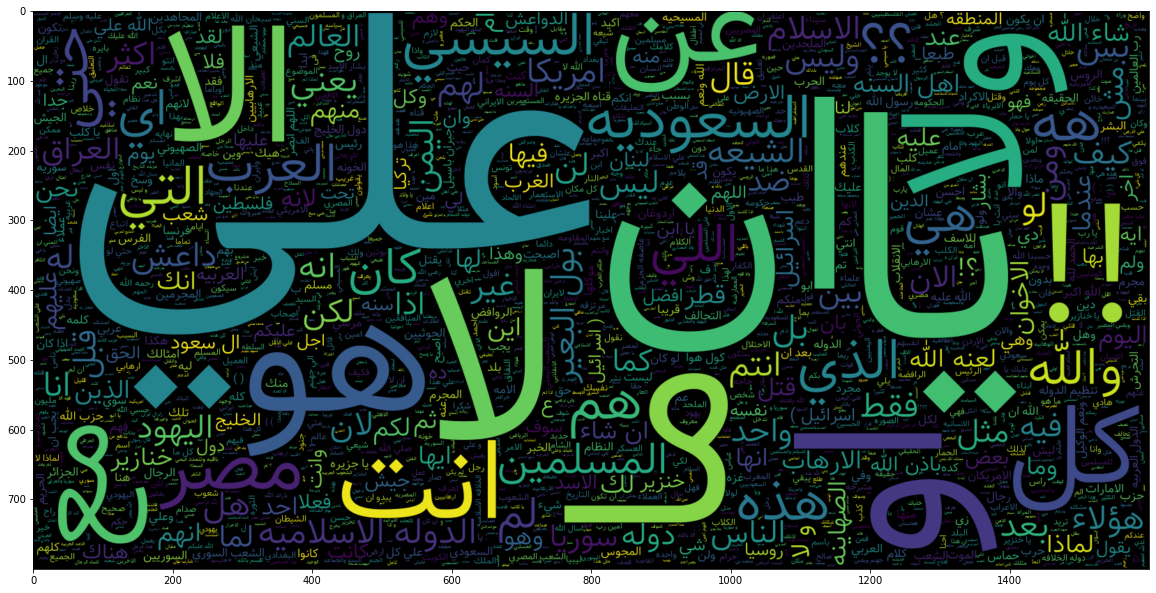

In [19]:
plt.figure(figsize = (20,20)) 
wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.off == 'OFF'].tweets))
image = wc.to_image()
image.save('wordcloudoff.png')
plt.imshow(wc , interpolation = 'bilinear')

# Train and Test Split

In [20]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 30000
MAX_SEQUENCE_LENGTH = 30


In [21]:
train_data, val_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(val_data))

Train Data size: 45917
Test Data size 11480


In [22]:
train_data.head(10)


,tweets,off
25014,اسوشيتد برس : عيوب كبيره منظومه امن مطار شرم ا...,OFF
30859,الضربه الاولي لحلفاء السعوديه لما تكنه روسيا ك...,OFF
18993,لزم ندحر الشيعه بكل شي متحسن عليه وسوفا ننطلق ...,OFF
29094,ماحن اعجمي علي عربي قط ورب الكعبه !! ان صدقتم ...,NOT_OFF
37498,لا يحق للجزيره نشر ترحم علي ذلك القاتل المجوسي...,OFF
33797,اغلب الناس تتحدث عن السيسي وتتناسي ان السيسي م...,OFF
16275,ويقول الشباب مايفهمون بشغلات الحريم,OFF
27984,زياده عدد جنودهم يعني زياده عدد قتلاهم يعني زي...,OFF
36601,ويبقي التخلف سيد الموقف تهانينا وعقبال ما تروح...,OFF
36700,نقول للعربي الفارسي ما قاله الشاعر العربي ( لك...,OFF


In [23]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweets)
tokenizer.fit_on_texts(val_data.tweets)

tokenizer.fit_on_texts(test.tweets)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)


# tok=text.Tokenizer(num_words=max_features,lower=True)
# tok.fit_on_texts(list(X_train)+list(X_test))
# X_train=tok.texts_to_sequences(X_train)
# X_test=tok.texts_to_sequences(X_test)
# x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
# x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

Vocabulary Size : 139784


In [24]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweets),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(val_data.tweets),
                       maxlen = MAX_SEQUENCE_LENGTH)

test=pad_sequences(tokenizer.texts_to_sequences(test.tweets),maxlen=MAX_SEQUENCE_LENGTH)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)
print("Testing X Shape:",test.shape)


Training X Shape: (45917, 30)
Testing X Shape: (11480, 30)
Testing X Shape: (2000, 30)


In [25]:
labels = train_data.off.unique().tolist()
labels

['OFF', 'NOT_OFF']

In [26]:
encoder = LabelEncoder()
encoder.fit(train_data.off.to_list())
encoder.fit(val_data.off.to_list())
# encoder.fit(actual.off.to_list())

y_train = encoder.transform(train_data.off.to_list())
y_test = encoder.transform(val_data.off.to_list())
# actual = encoder.transform(actual.off.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
# actual = actual.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
# print("actual shape:", actual.shape)

y_train shape: (45917, 1)
y_test shape: (11480, 1)


# Word embedding

In [27]:
# !wget http://mazajak.inf.ed.ac.uk:8000/get_sg_250

# !wget https://www.dropbox.com/s/ce9phmmawoe1ure/Twt-CBOW.zip

In [28]:
# !unzip Twt-CBOW.zip
# !gunzip -k get_sg_250.bin

In [29]:
# !ls

In [30]:
GLOVE_EMB = '/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/WE/Twt-CBOW/Twt-CBOW'
EMBEDDING_DIM = 300
LR = 1e-5
BATCH_SIZE = 1024
EPOCHS = 150
MODEL_PATH = '/content/best_model.hdf5'

In [31]:
# load the model
modelwv = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/WE/Twt-CBOW/Twt-CBOW')

In [32]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in modelwv.wv.vocab:
      embedding_vector = modelwv[word]
    else:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [33]:
print(embedding_matrix.shape)
# EMBEDDING_DIM=300


(139784, 300)


In [34]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Model Training - LSTM


In [35]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from keras.layers import Dropout,Embedding,GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model


In [36]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [38]:
# history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
#                     validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss',patience=5)])

Epoch 1/150
45/45 [==============================] - 37s 48ms/step - loss: 0.6865 - accuracy: 0.6153 - val_loss: 0.6838 - val_accuracy: 0.6135
Epoch 2/150
45/45 [==============================] - 1s 28ms/step - loss: 0.6796 - accuracy: 0.6163 - val_loss: 0.6777 - val_accuracy: 0.6135
Epoch 3/150
45/45 [==============================] - 1s 28ms/step - loss: 0.6736 - accuracy: 0.6163 - val_loss: 0.6720 - val_accuracy: 0.6135
Epoch 4/150
45/45 [==============================] - 1s 28ms/step - loss: 0.6684 - accuracy: 0.6163 - val_loss: 0.6676 - val_accuracy: 0.6135
Epoch 5/150
45/45 [==============================] - 1s 29ms/step - loss: 0.6649 - accuracy: 0.6163 - val_loss: 0.6648 - val_accuracy: 0.6135
Epoch 6/150
45/45 [==============================] - 1s 28ms/step - loss: 0.6626 - accuracy: 0.6163 - val_loss: 0.6631 - val_accuracy: 0.6135
Epoch 7/150
45/45 [==============================] - 1s 28ms/step - loss: 0.6612 - accuracy: 0.6163 - val_loss: 0.6619 - val_accuracy: 0.6135
Epoch

In [39]:
scores = model.evaluate(x_train,y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 65.18%


In [40]:
y_pred = model.predict(test,batch_size=10,verbose=1)
# print(x_test[:2])
# print(y_pred[:2])
# y_classes= np.argmax(y_pred,axis=1)
# print(y_classes)
# decoder=list(encoder.inverse_transform(y_classes))
# encoder.inverse_transform(y_classes)
# print(y_pred.tolist())
# print(decoder)
from itertools import chain
print(type(y_pred))
# y_pred = list(chain.from_iterable(y_pred))
y_pred = np.argmax(y_pred, axis=-1)
print(type(y_pred))


200/200 [==============================] - 1s 3ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [41]:
# actual.columns=['off']
actual.off = pd.Categorical(actual.off)
actual['OffCode'] = actual.off.cat.codes
y_actual=actual['OffCode']
actual.head()
print(type(actual.off.to_list()))
# print(actual.off.to_list())
# y_actual = np.array(list(chain.from_iterable(actual.off.to_list())))
# print(type(y_actual))
# y_actual = np.argmax(y_actual, axis=-1)
# print(type(y_actual))


<class 'list'>


In [42]:
from sklearn.metrics import accuracy_score
# print(y_classes)
# print(accuracy_score(y_actual, y_classes))


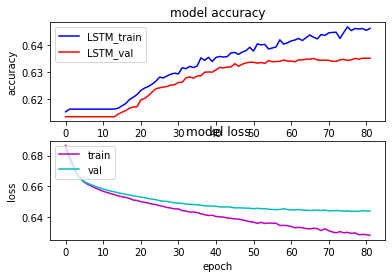

In [43]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [44]:
# def decode_sentiment(score):
#     return "NOT_OFF" if score>0.5 else "OFF"


# scores = model.predict(test, verbose=1, batch_size=100)
# print(scores)
# y_pred_1d = [decode_sentiment(score) for score in scores]
# type(y_pred_1d)

#Confusion Matrix¶


In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report

# # def set_confusion_matrix(clf, X, y, title):
# #     plot_confusion_matrix(clf, X, y)
# #     plt.title(title)
# #     plt.show()

# confusion_matrix( y_actual, y_pred)



In [47]:
# y_actual=y_actual.reshape(-1,1)
# y_pred=y_pred.reshape(-1,1)

# cnf_matrix = confusion_matrix(y_actual, y_pred)
confusion_matrix(y_actual, y_pred)
# plt.figure(figsize=(6,6))
# plot_confusion_matrix(cnf_matrix, classes=y_actual.unique(), title="Confusion matrix")
# plt.show()

array([[1598,    0],
       [ 402,    0]])

In [48]:
#Classification Scores

print(classification_report(y_actual, y_pred))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1598
           1       0.00      0.00      0.00       402

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
